In [1]:
import psycopg2 as pg2
import pandas as pd
import math

In [2]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='')

print ("Reading Dataset")
df = pd.read_sql ("""Select * from auction_full where auction_date >= """, conn)

Connecting to SQL
Reading Dataset


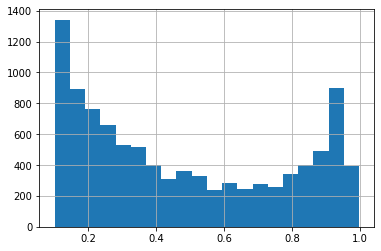

In [77]:
df.perc_to_bin[(df.perc_to_bin > .1 ) & (df.perc_to_bin < 1)&(df.giveup)].hist(bins=20)

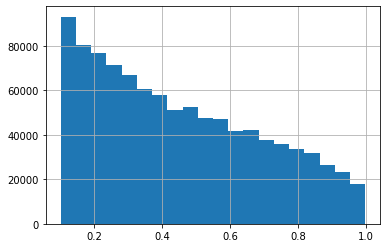

In [78]:
df.perc_to_bin[(df.perc_to_bin > .1 ) & (df.perc_to_bin < 1)&(df.giveup==False)].hist(bins=20)

In [161]:
df["bucket"]=df.perc_to_bin.apply(lambda x: int(round(int(x*300))/30.0))

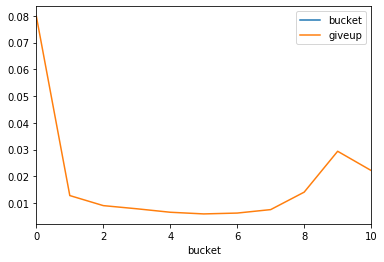

In [167]:
df.groupby("bucket").mean().loc[:,["bucket", "giveup"]].head(11).plot()

In [153]:
df.groupby("bucket").mean().loc[:,["perc_to_bin", "giveup"]].head(11)

,perc_to_bin,giveup
bucket,,
0,0.043888,0.079815
1,0.146587,0.012848
2,0.246529,0.009094
3,0.346163,0.007915
4,0.446733,0.006616
5,0.547500,0.005994
6,0.647057,0.006311
7,0.746305,0.007604
8,0.845803,0.014124


In [168]:
conn.close()

In [2]:
from BuildModel import PennyModel
import psycopg2 as pg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle
from datetime import datetime, date, timedelta
import importlib

In [3]:
def get_list_of_dates():

    sdate = date(2020, 2, 23)   # start date
    edate = date(2020, 2, 24)   # end date

    delta = edate - sdate       # as timedelta

    return [pd.Timestamp(sdate + timedelta(days=i)) for i in range(delta.days + 1)]
        
get_list_of_dates()

[Timestamp('2020-02-23 00:00:00'), Timestamp('2020-02-24 00:00:00')]

In [4]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='')

print ("Reading Dataset")
df = pd.read_sql ("""Select *  from auction_full order by auctiontime""", conn)

print ("Splitting into Train/Test Sets")
#df = df.sort_values("auctiontime")
y = df['is_winner']
X = df

Connecting to SQL
Reading Dataset
Splitting into Train/Test Sets


In [8]:
def print_profit_threshold (y_test, probs, X_test):
    for thresh in np.arange(0, 1.1, .05): # threshes:
        y_pred = probs >= thresh
        cm = confusion_matrix(y_test, y_pred)
        print("*****************************")
        print("thresh:", thresh)
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred) *100
        rec = recall_score(y_test, y_pred) *100
        print (f"Accuracy: {acc:.2f} Precision: {prec:.2f}  Recall:{rec:.2f} ")
        print(cm)
        true_positive_mask = (y_pred==True)&(y_test==True)
        profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100
        profit_per_bid = profit/sum(y_pred)
        print(f"profit: {profit:.2f}")
        print(f"profit per bid: {profit_per_bid:.2f}")
        winners = X_test[true_positive_mask].groupby("cashvalue").count()
        print(winners.is_winner)
        print("*****************************")
        print("")

In [9]:
date_list = get_list_of_dates()


for i in range(1, len(date_list)):
    train_cut_off  = date_list[i-1]
    test_cut_off = date_list[i]
    print (train_cut_off, test_cut_off)
    X_train = X[X.auctiontime <= train_cut_off]
    y_train = y[X.auctiontime <= train_cut_off]
    X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
    y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)#, random_state=0) 

    print ("Fitting Model")
    pm = PennyModel()
    pm.fit(X_train, y_train)

    print ("Calculating predictions")
    probs = pm.predict_proba(X_test)[:,1]
    threshes = np.unique(probs)
    threshes = threshes[threshes > .4]

    print_profit_threshold(y_test, probs, X_test)



2020-02-23 00:00:00 2020-02-24 00:00:00
Fitting Model
2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.65 Precision: 0.65  Recall:100.00 
[[    0 16046]
 [    0   105]]
profit: -3399.78
profit per bid: -0.21
cashvalue
6      15
10     16
20     13
33     18
37     19
40      7
58      5
62      2
64      6
100     4
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.65 Precision: 0.65  Recall:100.00 
[[    0 16046]
 [    0   105]]
profit: -3399.78
profit per bid: -0.21
cashvalue
6      15
10     16
20     13
33     18
37     19
40      7
58      5
62      2
64      6
100     4
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.1
Accuracy: 0.65 Precision: 0.65  Recall:100.00 
[[    0 16046]
 [    0   105]]
profit: -3399.78
profit per bid: -0.21
cashvalue
6      15
10     16
20     13
33 

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [53]:
y_pred = probs >= .8

X_test[y_pred].shape

(220, 78)

Plotting features


Text(0.5, 0, 'Average contribution to information gain')

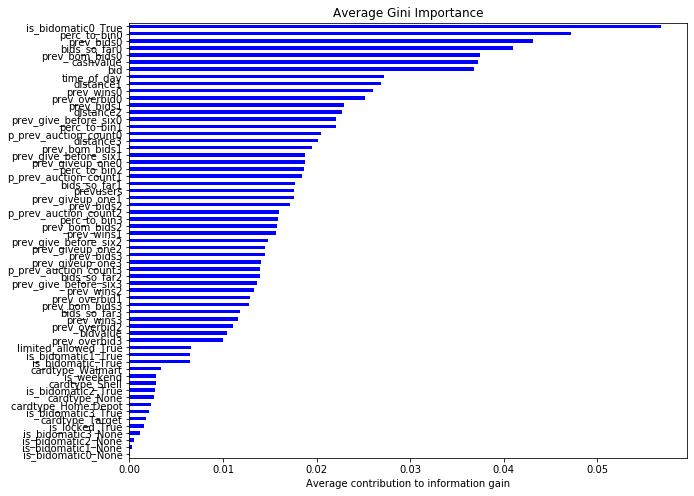

In [10]:

print ("Plotting features")
# Plot the feature importance
feat_scores = pm.get_feature_scores()
feat_scores = feat_scores.sort_values()
fig, ax = plt.subplots()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')



In [157]:
X_test[(probs > .6)].groupby("cardtype").is_winner.count().head(50)

cardtype
Amazon        13797
Home Depot     1369
None          14946
Shell          6251
Target         3643
Walmart        5528
Name: is_winner, dtype: int64

In [158]:
X_test["prob"] = probs > .6

/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [165]:
X_test.groupby(["is_bidomatic0","prob"]).mean()

auctionid  is_winner  cashvalue  cardvalue       fee  \
is_bidomatic0 prob                                                             
False         False  5.579744e+08   0.004597  63.435255  37.202811  1.276415   
              True   5.314351e+08   0.016228  41.722465  24.174205  0.943895   
True          False  5.565080e+08   0.001949  63.800840  39.593450  1.389779   
              True   5.303516e+08   0.010489  37.161703  23.826247  0.945472   

                      bidvalue  limited_allowed  is_locked         bid  \
is_bidomatic0 prob                                                       
False         False  65.581111         0.309497   0.294496  420.056325   
              True   43.870651         0.277433   0.221974  212.985805   
True          False  60.518476         0.249776   0.213906  346.425474   
              True   33.338640         0.211151   0.300181  239.660111   

                     is_bidomatic  ...  bom_bids_so_far3  bom_streak3  \
is_bidomatic0 prob                 ...                                  
False         False      0.628294  ...         28.679839    15.617112   
              True       0.720636  ...         14.373425     7.421713   
True          False      0.805810  ...         25.001725    13.043358   
              True       0.830430  ...         27.252327    15.954209   

                     perc_to_bin3  p_prev_auction_count3  prev_overbid3  \
is_bidomatic0 prob                                                        
False         False      0.236595             115.474403       0.069192   
              True       0.214227             107.473748       0.051186   
True          False      0.197456             110.687271       0.059939   
              True       0.348683             104.070326       0.053110   

                     prev_giveup_one3  prev_give_before_six3  prev_wins3  \
is_bidomatic0 prob                                                         
False         False          0.248195               0.464856    0.140230   
              True           0.270622               0.514245    0.120976   
True          False          0.259120               0.485300    0.129384   
              True           0.269415               0.510400    0.118611   

                     prev_bids3  prev_bom_bids3  
is_bidomatic0 prob                               
False         False   37.159819       28.527811  
              True    26.834702       20.325800  
True          False   33.318953       25.748146  
              True    26.303400       20.024208  

[4 rows x 67 columns]

In [148]:
X_test.groupby("prev_wins_bin").is_winner.mean()

prev_wins_bin
(-0.001, 0.05]    0.008728
(0.05, 0.1]       0.006418
(0.1, 0.15]       0.005427
(0.15, 0.2]       0.003929
(0.2, 0.25]       0.002835
(0.25, 0.3]       0.002669
(0.3, 0.35]       0.002410
(0.35, 0.4]       0.002361
(0.4, 0.45]       0.001622
(0.45, 0.5]       0.003214
(0.5, 0.55]       0.001992
(0.55, 0.6]       0.002457
(0.6, 0.65]       0.000958
(0.65, 0.7]       0.002618
(0.7, 0.75]       0.000000
(0.75, 0.8]            NaN
(0.8, 0.85]            NaN
(0.85, 0.9]            NaN
(0.9, 0.95]            NaN
(0.95, 1.0]       0.004425
Name: is_winner, dtype: float64

In [59]:
def shuffle_column(X, feature_index):
    ''' 
    Parameters
    ----------
    X: numpy array
    feature_index: int
    
    Returns
    -------
    X_new: numpy array
    
    Returns a new array identical to X but
    with all the values in column feature_index
    shuffled
    '''   
    
    X_new = X.copy()
    X_new[feature_index] = np.random.permutation(X_new[feature_index])
    return X_new    

def permutation_importance(model, X_test, y_test, scorer=accuracy_score):
    ''' Calculates permutation feature importance for a fitted model
    
    Parameters
    ----------
    model: anything with a predict() method
    X_test, y_test: numpy arrays of data
        unseen by model
    scorer: function. Should be a "higher is better" scoring function,
        meaning that if you want to use an error metric, you should
        multiply it by -1 first.
        ex: >> neg_mse = lambda y1, y2: -mean_squared_error(y1, y2)
            >> permutation_importance(mod, X, y, scorer=neg_mse)
    
    Returns
    -------
    feat_importances: numpy array of permutation importance
        for each feature
    
    '''
    
    feat_importances = np.zeros(X_test.shape[1])
    test_score = scorer(model.predict(X_test), y_test)
    for i in range(X_test.shape[1]):
        X_test_shuffled = shuffle_column(X_test, X_test.columns[i])
        test_score_permuted = scorer(y_test, model.predict(X_test_shuffled))
        print(test_score, test_score_permuted)
        feat_importances[i] = test_score - test_score_permuted
    return feat_importances

In [60]:
X_test.columns

Index(['auctionid', 'is_winner', 'cardtype', 'cashvalue', 'cardvalue', 'fee',
       'bidvalue', 'limited_allowed', 'is_locked', 'auctiontime', 'bid',
       'is_bidomatic', 'bids_so_far', 'username', 'prevusers', 'giveup',
       'eventual_bids', 'eventual_win_price', 'debut', 'bom_streak',
       'bom_bids_so_far', 'perc_to_bin', 'username0', 'distance0',
       'is_bidomatic0', 'bids_so_far0', 'bom_bids_so_far0', 'bom_streak0',
       'perc_to_bin0', 'p_prev_auction_count0', 'prev_overbid0',
       'prev_giveup_one0', 'prev_give_before_six0', 'prev_wins0', 'prev_bids0',
       'prev_bom_bids0', 'username1', 'distance1', 'is_bidomatic1',
       'bids_so_far1', 'bom_bids_so_far1', 'bom_streak1', 'perc_to_bin1',
       'p_prev_auction_count1', 'prev_overbid1', 'prev_giveup_one1',
       'prev_give_before_six1', 'prev_wins1', 'prev_bids1', 'prev_bom_bids1',
       'username2', 'distance2', 'is_bidomatic2', 'bids_so_far2',
       'bom_bids_so_far2', 'bom_streak2', 'perc_to_bin2',
       

In [62]:
pis = permutation_importance(pm, X_test, y_test)

2. Transforming data
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226673 0.5561884713020866
2. Transforming data
0.5555073989226673 0.5470868676862114
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226673 0.552906940746703
2. Transforming data
0.5555073989226673 0.5556312302643799
2. Transforming data
0.5555073989226673 0.5563742183146554
2. Transforming data
0.5555073989226673 0.5548882422141044
2. Transforming data
0.5555073989226673 0.5490062534827564
2. Transforming data
0.5555073989226673 0.5569933750232183
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226673 0.5560027242895177
2. Transforming data
0.5555073989226673 0.5555073989226673
2. Transforming data
0.5555073989226

In [70]:
for c, pi in sorted(zip(X_test.columns, pis), key=lambda x: abs(x[1])):
    print(c, pi)
    
key=lambda x: x[1]

auctionid 0.0
is_winner 0.0
cardvalue 0.0
fee 0.0
bids_so_far 0.0
username 0.0
giveup 0.0
eventual_bids 0.0
eventual_win_price 0.0
debut 0.0
bom_streak 0.0
bom_bids_so_far 0.0
perc_to_bin 0.0
username0 0.0
distance0 0.0
bom_bids_so_far0 0.0
bom_streak0 0.0
username1 0.0
bom_bids_so_far1 0.0
bom_streak1 0.0
username2 0.0
is_bidomatic2 0.0
bom_bids_so_far2 0.0
bom_streak2 0.0
username3 0.0
bom_bids_so_far3 0.0
bom_streak3 0.0
limited_allowed -0.00012383134171256582
prev_bom_bids3 -0.00030957835428147007
prev_giveup_one1 0.0004334096959940359
prev_give_before_six2 0.0004334096959940359
prevusers -0.0004953253668503743
prev_give_before_six1 0.0004953253668503743
auctiontime 0.0006191567085629401
cardtype -0.0006810723794192786
is_locked -0.0008668193919880718
is_bidomatic3 -0.0008668193919880718
prev_giveup_one0 0.0012383134171258803
bids_so_far3 0.0013002290879821077
is_bidomatic -0.001485976100551012
prev_give_before_six0 -0.001795554454832482
perc_to_bin1 -0.001795554454832482
is_bidoma

In [58]:
np.random.permutation(X_new["cardtype"])

array(['Amazon', 'Walmart', 'None', ..., 'Target', 'Target', 'Amazon'],
      dtype=object)